# Multi-Objective Optimization with Folio

This notebook demonstrates multi-objective Bayesian optimization.

We'll optimize a synthetic problem with two competing objectives:
- **Maximize yield** (higher is better)
- **Minimize cost** (lower is better)

There's no single "best" solution - instead, we find the Pareto front of
non-dominated solutions representing different trade-offs.

## Setup

In [1]:
import tempfile
import numpy as np
import matplotlib.pyplot as plt

from folio.api import Folio
from folio.core.config import RecommenderConfig, TargetConfig
from folio.core.schema import InputSpec, OutputSpec

/opt/homebrew/Caskroom/miniconda/base/envs/folio/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Create a temporary database
db_path = tempfile.mktemp(suffix=".db")
folio = Folio(db_path=db_path)
print(f"Database: {db_path}")

Database: /var/folders/h9/gpnygt8x227c24jhrwxd23pr0000gn/T/tmphxkbo7ax.db


## Define the Synthetic Problem

A reaction with one input parameter `x` in [0, 10]:
- **Yield**: Peaks around x=8 (represents reaction efficiency)
- **Cost**: Increases linearly with x (represents reagent cost)

Trade-off: Higher x gives better yield but costs more.

In [3]:
def synthetic_experiment(x: float) -> tuple[float, float]:
    """Simulated experiment with competing yield and cost objectives."""
    noise_yield = np.random.normal(0, 1)
    noise_cost = np.random.normal(0, 0.5)
    
    # Yield: quadratic, peaks at x=8
    yield_val = 100 - 2 * (x - 8)**2 + noise_yield
    
    # Cost: linear, higher x costs more
    cost = 10 + 5 * x + noise_cost
    
    return max(0, yield_val), max(0, cost)

## Create a Multi-Objective Project

Key differences from single-objective:
1. Multiple `target_configs` - one per objective
2. `reference_point` - defines the "worst acceptable" values for hypervolume calculation
3. `surrogate="multitask_gp"` - models correlations between objectives
4. `mo_acquisition="nehvi"` - Noisy Expected Hypervolume Improvement

In [4]:
folio.create_project(
    name="yield_vs_cost",
    inputs=[
        InputSpec("x", "continuous", bounds=(0.0, 10.0)),
    ],
    outputs=[
        OutputSpec("yield"),
        OutputSpec("cost"),
    ],
    target_configs=[
        TargetConfig(objective="yield", objective_mode="maximize"),
        TargetConfig(objective="cost", objective_mode="minimize"),
    ],
    # Reference point: worst acceptable outcome (low yield, high cost)
    # Since we maximize yield and minimize cost internally (via negation),
    # the reference point uses the "bad" direction for each objective
    reference_point=[0.0, 100.0],
    recommender_config=RecommenderConfig(
        type="bayesian",
        surrogate="multitask_gp",
        mo_acquisition="nehvi",
        n_initial=3,
    ),
)
print("Multi-objective project created!")

Multi-objective project created!


## Run the Optimization Loop

Same workflow as single-objective, but now we're exploring the Pareto front.

In [5]:
N_ITERATIONS = 15

for i in range(N_ITERATIONS):
    # Get suggestion
    suggestion = folio.suggest("yield_vs_cost")[0]
    x = suggestion["x"]
    
    # Run experiment
    yield_val, cost = synthetic_experiment(x)
    
    # Record observation
    folio.add_observation(
        project_name="yield_vs_cost",
        inputs={"x": x},
        outputs={"yield": yield_val, "cost": cost},
    )
    
    print(f"Iter {i+1:2d}: x={x:.2f} -> yield={yield_val:.1f}, cost={cost:.1f}")

Iter  1: x=5.68 -> yield=90.1, cost=37.4
Iter  2: x=0.22 -> yield=0.0, cost=11.5
Iter  3: x=3.28 -> yield=54.2, cost=26.5


/opt/homebrew/Caskroom/miniconda/base/envs/folio/lib/python3.11/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:656.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


Iter  4: x=5.16 -> yield=84.5, cost=36.0
Iter  5: x=10.00 -> yield=91.4, cost=60.1
Iter  6: x=7.86 -> yield=99.7, cost=49.7
Iter  7: x=8.79 -> yield=97.5, cost=53.6
Iter  8: x=7.51 -> yield=100.9, cost=47.1
Iter  9: x=8.25 -> yield=100.2, cost=51.0
Iter 10: x=7.69 -> yield=100.3, cost=48.4
Iter 11: x=9.42 -> yield=94.6, cost=56.4
Iter 12: x=9.11 -> yield=97.9, cost=55.4
Iter 13: x=8.54 -> yield=98.3, cost=53.5
Iter 14: x=9.71 -> yield=95.9, cost=58.4
Iter 15: x=9.27 -> yield=97.4, cost=55.4


## Identify the Pareto Front

A solution is **Pareto optimal** if no other solution is better in all objectives.

The Pareto front shows the best achievable trade-offs between yield and cost.

In [6]:
def is_pareto_optimal(costs: np.ndarray) -> np.ndarray:
    """Find Pareto-optimal points (minimize all objectives)."""
    n = len(costs)
    is_optimal = np.ones(n, dtype=bool)
    for i in range(n):
        for j in range(n):
            if i != j:
                # j dominates i if j is <= in all and < in at least one
                if np.all(costs[j] <= costs[i]) and np.any(costs[j] < costs[i]):
                    is_optimal[i] = False
                    break
    return is_optimal

In [7]:
# Get all observations
observations = folio.get_observations("yield_vs_cost")
yields = np.array([obs.outputs["yield"] for obs in observations])
costs = np.array([obs.outputs["cost"] for obs in observations])

# Convert to minimization problem for Pareto calculation
# (negate yield since we want to maximize it)
objectives = np.column_stack([-yields, costs])
pareto_mask = is_pareto_optimal(objectives)

print(f"Total observations: {len(observations)}")
print(f"Pareto-optimal solutions: {pareto_mask.sum()}")

Total observations: 15
Pareto-optimal solutions: 5


## Visualize the Pareto Front

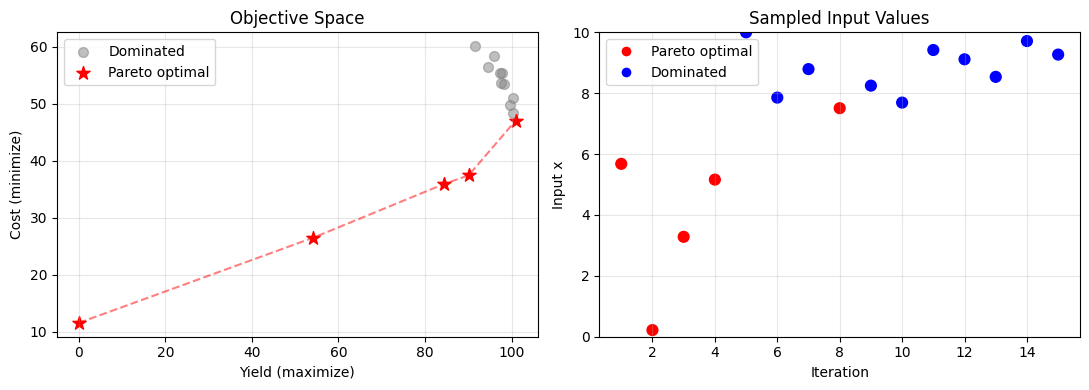

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))

# Left: Objective space with Pareto front
ax1.scatter(yields[~pareto_mask], costs[~pareto_mask], 
           c="gray", alpha=0.5, s=50, label="Dominated")
ax1.scatter(yields[pareto_mask], costs[pareto_mask], 
           c="red", s=100, marker="*", label="Pareto optimal")

# Connect Pareto points with a line (sorted by yield)
pareto_yields = yields[pareto_mask]
pareto_costs = costs[pareto_mask]
sort_idx = np.argsort(pareto_yields)
ax1.plot(pareto_yields[sort_idx], pareto_costs[sort_idx], "r--", alpha=0.5)

ax1.set_xlabel("Yield (maximize)")
ax1.set_ylabel("Cost (minimize)")
ax1.set_title("Objective Space")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: Input values over iterations
x_vals = [obs.inputs["x"] for obs in observations]
colors = ["red" if pareto_mask[i] else "blue" for i in range(len(observations))]
ax2.scatter(range(1, len(x_vals) + 1), x_vals, c=colors, s=60)
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Input x")
ax2.set_title("Sampled Input Values")
ax2.set_ylim(0, 10)
ax2.grid(True, alpha=0.3)

# Add legend for right plot
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker="o", color="w", markerfacecolor="red", markersize=8, label="Pareto optimal"),
    Line2D([0], [0], marker="o", color="w", markerfacecolor="blue", markersize=8, label="Dominated"),
]
ax2.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

## Pareto-Optimal Solutions

Let's examine the trade-offs discovered.

In [9]:
print("Pareto-optimal solutions (sorted by yield):")
print("="*50)

pareto_obs = [observations[i] for i in range(len(observations)) if pareto_mask[i]]
pareto_obs_sorted = sorted(pareto_obs, key=lambda o: o.outputs["yield"], reverse=True)

for obs in pareto_obs_sorted:
    print(f"  x={obs.inputs['x']:.2f}: yield={obs.outputs['yield']:.1f}, cost={obs.outputs['cost']:.1f}")

Pareto-optimal solutions (sorted by yield):
  x=7.51: yield=100.9, cost=47.1
  x=5.68: yield=90.1, cost=37.4
  x=5.16: yield=84.5, cost=36.0
  x=3.28: yield=54.2, cost=26.5
  x=0.22: yield=0.0, cost=11.5


## Summary

Multi-objective optimization with Folio:

1. **Define multiple targets** with `target_configs` (one per objective)
2. **Set a reference point** for hypervolume calculation
3. **Use multi-task GP** (`surrogate="multitask_gp"`) to model objective correlations
4. **NEHVI acquisition** explores the Pareto front efficiently

The result is a set of Pareto-optimal solutions. A domain expert can then
choose the best trade-off based on practical constraints.

In [ ]:
# Cleanup
folio.delete_project("yield_vs_cost")
print("Demo complete!")